In [163]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
from  math import *
import matplotlib.pyplot as plt
import scipy.optimize as so
import scipy.special as sp
import mpmath as mp
import random

In [164]:
N_md = 10#Leapfrog integration steps
N_cfg = 10000
phi=0
p_0 = 0 
ar=0



# This is just defining of variables. 

In [165]:
def leapfrog_plot():
    global N_md
    p=0.2
    phi=0
    for i in range(100):
        H_0=H(p,phi)
        N_md=i*10+10
        p_new,phi_new=leapfrog(p,phi)
        plt.plot(i*10+10,abs((H(p_new,phi_new)-H_0)/H_0), 'x', color='b')
        #print(p,phi)
    plt.semilogy()    
    plt.show() 

Same idea as last time

In [166]:
def leapfrog(p_l,phi_l):
    # p_0_1,p_0_2,p_0_3,
    global beta 
    global f
    global x
    global J
    global N 
    global h
    global N_md
    
    eps=.1/N_md
    phi_l=phi_l+eps/2*p_l
 
    for i in range(N_md-1):
        p_l=p_l-eps*(2*phi_l)*(1+1/(2+phi_l**2))
        phi_l=phi_l+eps*p_l
    p_l=p_l-eps*(2*phi_l)*(1+1/(2+phi_l**2))
    phi_l=phi_l+eps/2*p_l
    return p_l,phi_l

input: p_l, phi_l; output: p_f,phi_f  
code as explained on the sheet

Last time u commented that the last haft step for phi should be back, but I think forward is correct, because this way we do $N_{md}$ steps forward.  

In [167]:
def H(p_h,phi_h):

    return  p_h**2/2+phi_h**2+np.log(2+phi_h**2)

input p,phi: ; output: H(p,phi)

In [168]:
def HMC(): #Does one iteration of the Markov-Chain and return phi
    global N_md
    global p_0
    global phi
    #global p
    global ar
    
    p_h=np.random.normal(loc=00.0, scale=1.0)
    p_l,phi_l = leapfrog(p_h,phi)    
    
    
    P_acc = np.exp(float(H(p_h,phi)-H(p_l,phi_l)))
    
        
    if P_acc > np.random.rand(): 
        
        phi = phi_l
        ar=ar+1

HMC copied from last exercise :) 

In [169]:
def autocorrelation(o_chain,t,mu_o):
    c_t=0
    for i in range(N_cfg-t):
        c_t+=(o_chain[i]-mu_o)*(o_chain[i+t]-mu_o)
    c_t=c_t/(N_cfg-t)
    return c_t

input markov_chain_observables,t,$\mu_O$: ; output: $C^0(t)$ see sheet 

In [170]:
def normalized_autocorrelation(o_chain,t):
    mu_o=np.average(o_chain)
    Gamma_t=autocorrelation(o_chain,t,mu_o)/autocorrelation(o_chain,0,mu_o)
    return Gamma_t

input markov_chain_observables,t: ; output: $\Gamma(t)$ see sheet 

In [171]:
def int_auto_corr(o_chain):
    tau_int=0
    tau_int=0.5*normalized_autocorrelation(o_chain,0)
    for i in range(N_cfg):
        temp=normalized_autocorrelation(o_chain,i+1)
        if temp>0:
            tau_int+=temp
        else: return tau_int
    return tau_int

input: markov_chain_observables output: $\tau_{int}$ see sheet

In [172]:
def markov_chain():
    global N_cfg
    global x
    global phi
    global ar
    
    
    phi_chain=[]
    for i in range(N_cfg):
        HMC()
        phi_chain.append(phi)
    print(ar/(N_cfg),'Acceptence rate')
    ar=0
    phi_chain=np.array(phi_chain)
    o_chain=np.cos(np.sqrt(1+phi_chain**2))
    return o_chain

creates markov chain as always but convertes the entries in observables. so it "returns" a markov chain of observables

In [173]:
def binning(o_chain,tau_int):
    o_chain_new=[]
    tau_int=int(tau_int)
    o_chain=o_chain[0:N_cfg-N_cfg%tau_int]
    for i in range(int((N_cfg-N_cfg%tau_int)/tau_int)):
        o_chain_new.append(np.average(o_chain[i*tau_int:(i+1)*tau_int]))
    return o_chain_new

input: o_chain,tau_int output: binned chain, with bin size tau_int

In [174]:
def print_nor_auto(o_chain,tau_int):
    N_cfg_temp=len(o_chain)
    normal_auto= []
    exp= []
    for i in range(N_cfg_temp):
        normal_auto.append(normalized_autocorrelation(o_chain,i))
        exp.append(np.exp(-i/tau_int))
    plt.plot(normal_auto,label="data")
    plt.plot(exp,label="theo")
    plt.legend()
    plt.show()

This function prints the normalized autocorrelation and $e^{-t/\tau}$. This is very slow and should only be used for short chains. Thats ok, because the autocorrelation can be studied for the first ~100 entries of the chain. 

In [175]:
def show_auto_dec(o_chain,tau_int):
    global N_cfg
    tau_int_final=[]
    tau_int_final.append(tau_int)
    for i in range(2,int(tau_int)):
        N_cfg=len(o_chain)
        o_chain_new=binning(o_chain,i)
        N_cfg=len(o_chain_new)
        tau_int_new=int_auto_corr(o_chain_new)
        tau_int_final.append(tau_int_new)
    N_cfg=len(o_chain)    
    plt.plot(tau_int_final)
    plt.xlabel(r"$N_{bin}$")
    plt.ylabel(r"$\tau_{int}(N_{bin})$")
    plt.show()

input: o_chain,tau_int output: None  
this function computes and plots the $\tau_{int}$ for different $N_{bin}$

In [176]:
def show_error_inc(o_chain,tau_int):
    boot_var_final=[]
    for i in range(2,3*int(tau_int)):
        o_chain_new=binning(o_chain,i)
        o_chain_boot=booti(o_chain_new, 200)
        boot_var_final.append(np.sqrt(np.var(o_chain_boot)))   
    plt.plot(boot_var_final)
    plt.xlabel(r"$N_{bin}$")
    plt.ylabel(r"$\sqrt{var(bootstrap)}$")
    plt.show()    

input: o_chain,tau_int output: None  
calculates and plots the variance in the bootstrap_o_chain-array for different bin sizes 

In [177]:
def booti(o_chain,N):
    boot_array=[]
    boot_array_final=[]
    for i in range(N):
        for j in range(len(o_chain)):
            boot_array.append(random.choice(o_chain))
        boot_array_final.append(np.average(boot_array))
        boot_array=[]
    return boot_array_final

input: o_chain,N output: bootstrap_o_chain-array  
picks randomly as many elements from the binned chain as the binned chain has elements in itself and then builds a new o_chain from the averages of $N$ of these randomly arranged arrays.

In [178]:
def booti_ens(N):
    global N_cfg
    booti_error_ens=[]
    for i in range(20):
        N_cfg=(i+1)*50000
        o_chain=markov_chain()
        o_chain_new=binning(o_chain,N)
        o_chain_boot=booti(o_chain_new, 200)
        print(np.average(o_chain_boot),N_cfg)
        booti_error_ens.append(np.sqrt(np.var(o_chain_boot)))
    plt.plot(np.arange(50000,1050000,50000),booti_error_ens,label="data")
    plt.xlabel(r"$N_{ens}$")
    plt.ylabel(r"$\sqrt{var(bootstrap)}$")
    plt.plot(np.arange(50000,1050000,50000),1/(6*np.sqrt(np.arange(50000,1050000,50000)/N)),label="theo")
    plt.show()

input: N output:  
calculates the variance in the bootstrap_o_chain-array for different $N_{ens}$ and plots them. The bin-size is always N.

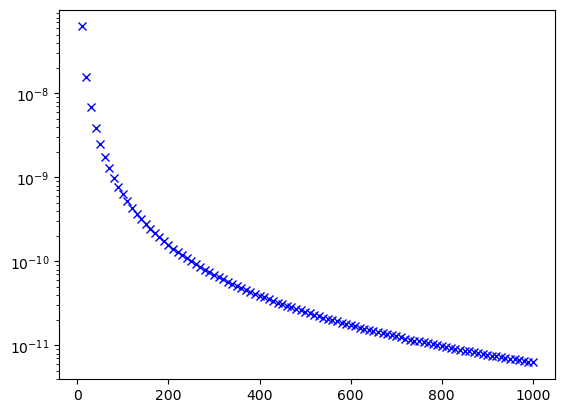

In [179]:
leapfrog_plot()

The graph looks like we expected it. It shows that for large $N_{md}$ the energy of the old and new configuration is almost the same. This will later be important to achieve a high acceptance probability.  

In [180]:
N_md=3

In [181]:
o_chain=markov_chain()

0.9999 Acceptence rate


In [182]:
tau_int=int_auto_corr(o_chain)

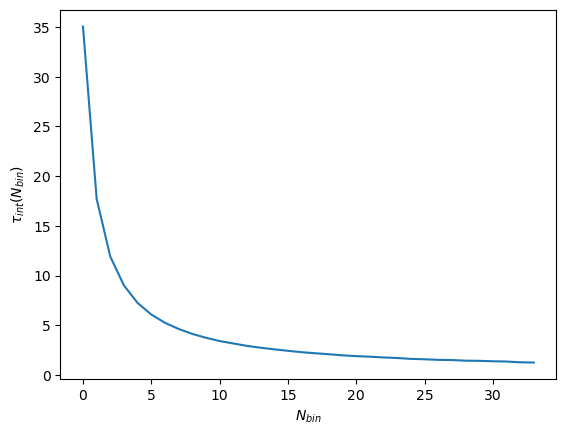

In [183]:
show_auto_dec(o_chain,tau_int)

This graph shows the decrease of $\tau_{int}$ for increasing bin size. This is to be expected, because elements in the binned chain have less autocorrelation. 

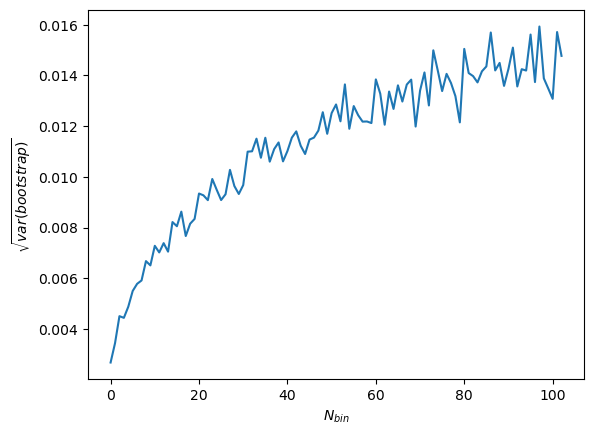

In [184]:
show_error_inc(o_chain,tau_int)

This graph shows the increase in variance for increasing bin size. This is expected because if we increase the bin size we eliminate autocorrelation and values in then bootstrap arrays are more randomly distributed which at the end leads to higher variance. The variance is a lot lower than the expected theoretical value of $\sigma^2=0.0349816$. One reason for the low variance can be the autocorrelation and the other reason is that the bootstrap-algo also decreases the variance by a factor of $\frac{1}{\sqrt{n}}$ where $n$ is the number of bins in the binned chain. 

1.0 Acceptence rate


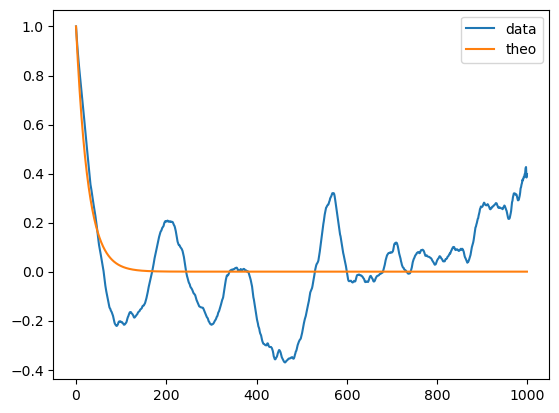

In [185]:
N_cfg=1000
o_chain=markov_chain()
tau_int=int_auto_corr(o_chain)
print_nor_auto(o_chain,tau_int) #only use for small N_cfg 

This graph shows the normalized autocorrelation together with $e^{-t/\tau_{int}}$. One can see a good fit for the autocorrelation in the beginning of the chain. 

0.99996 Acceptence rate
0.405724956235717 50000
0.99999 Acceptence rate
0.4131848661375929 100000
0.9999466666666667 Acceptence rate
0.39689884684691035 150000
0.999955 Acceptence rate
0.39834883170325897 200000
0.999972 Acceptence rate
0.39548917583663695 250000
0.9999466666666667 Acceptence rate
0.399239064174179 300000
0.9999542857142857 Acceptence rate
0.396352132861327 350000
0.9999725 Acceptence rate
0.39642733214891634 400000
0.9999466666666667 Acceptence rate
0.4006299990989543 450000
0.999952 Acceptence rate
0.39871145624189963 500000
0.9999618181818182 Acceptence rate
0.3964085657276196 550000
0.9999683333333333 Acceptence rate
0.4005228073275174 600000
0.9999569230769231 Acceptence rate
0.40074630292437535 650000
0.9999528571428571 Acceptence rate
0.4002131059376059 700000
0.9999613333333334 Acceptence rate
0.399177751060533 750000
0.99995875 Acceptence rate
0.39606280669902544 800000
0.999964705882353 Acceptence rate
0.3997287870069974 850000
0.9999633333333333 Acceptence r

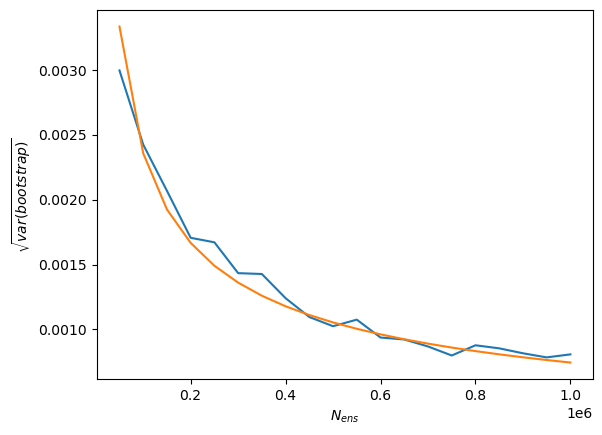

In [186]:
booti_ens(20)

This graph shows the decrease of variance in the bootstrap_o_chain for increasing $N_{ens}$. This i compared to ~$\frac{1}{\sqrt{N_{ens}/N_{bin}}}$. The good fit shows that the variance scales with $\frac{1}{\sqrt{N_{ens}/N_{bin}}}$. With increasing $N_{ens}$ the size of the binned chain is increased as well and thereby also the number of elements in the bootstrap arrays is increased. The more values we pick here the better we can apply the Central Limit Theorem and the average values in the bootstrap_o_chain array are normal-distributed with mean $<O>$ and their standard distribution scales with $\frac{1}{\sqrt{N_{ens}/N_{bin}}}$.